## feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
from openclsim.plot import get_step_chart, get_gantt_chart
import numpy as np

In [2]:
cutter_name    = 'Cutter T'
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
vessel_cost     = {'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                  'Barge I':5000,'Barge II':5000,'Barge III':5000,
                  'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                  'Cutter T':25000} # EUR/day
# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

amount_range = [4,6]
duration_range = [2000,3000]

from_site_name = 'Trench'
to_site_name   = 'Reclamation'

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [4]:
def run(NR_BARGES, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site = Site(**data_from_site)

    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)

    vessels = {}

    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels[cutter_name] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        amount = np.random.randint(amount_range[0], amount_range[1]) # handle loading
        duration=np.random.randint(duration_range[0], duration_range[1]) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle {vessel_name}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle {vessel_name}",
                registry=registry,
                sub_processes=[
                    model.BasicActivity(
                        env=my_env,
                        name=f"basic activity:"+vessels[vessel_name].name,
                        registry=registry,
                        duration=duration,
                        additional_logs=[vessels[vessel_name]],
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        from_site_name:from_site,
        to_site_name:to_site,
    }


In [5]:
%%time
nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
total_amount = 100
res = run(3,total_amount)
vessels = res['vessels']
activities = res['activities']
cutter = vessels[cutter_name]
to_site = res[to_site_name]
from_site = res[from_site_name]

CPU times: user 83.8 ms, sys: 11.4 ms, total: 95.2 ms
Wall time: 79 ms


In [27]:
fig = get_gantt_chart(vessels, id_map=activities)


In [16]:
fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

Plot only activities whose namespace (first letters) matches load*

In [29]:
def expand(a, namespace):
    n = len(namespace)
    sa = []
    if a.name[0:n]==namespace:
        sa.append(a)
    if hasattr(a, "sub_processes"):
        for s in a.sub_processes:
            if s.name[0:n]==namespace:
                sa.append(s)
            sa+=expand(s,namespace)
    return sa
all_activities = []
for a in [*activities]:
    all_activities+=expand(activities[a],'load')
all_activities
fig = get_gantt_chart(all_activities)

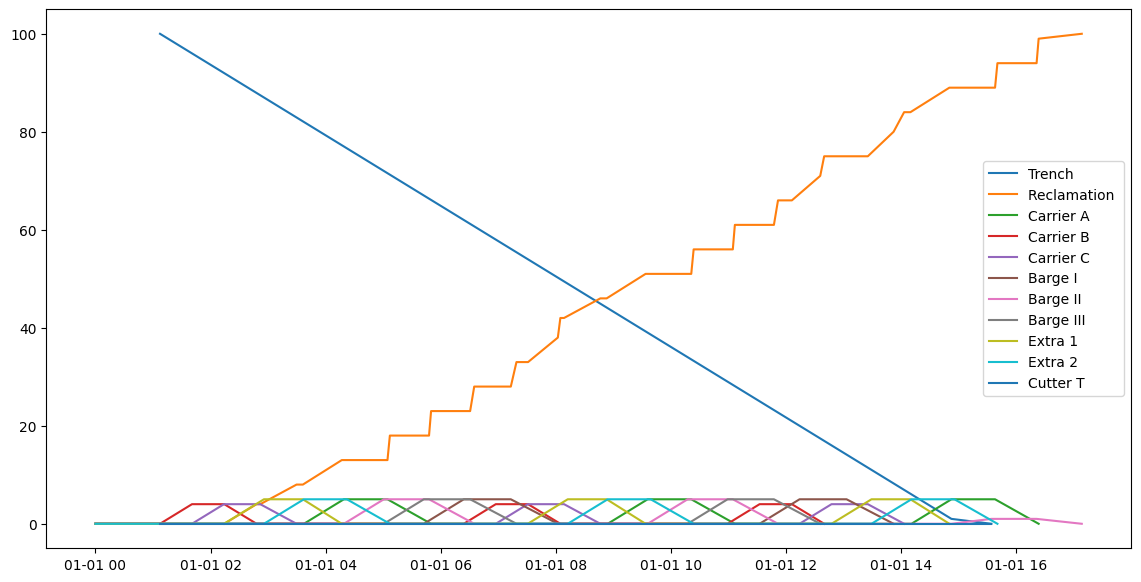

In [26]:
fig = get_step_chart([from_site, to_site, *vessels.values()])

In [22]:
def occupancy_analysis(vessels, cutter, activities, vessel_cost):
    data = []
    duration_theory_cutter = 0
    nr_trips_cutter = 0

    # barges
    for i, vessel_name in enumerate(vessels):
        if vessel_name!=cutter_name:
            vessel = vessels[vessel_name]
            activity = activities[f'activity{i}']

            log = pd.DataFrame(vessel.log)
            sub_act = activity.sub_processes[0].sub_processes[-1] # last phase of SequentialActivity ..
            nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "STOP")]) # .. ended
            nr_trips_cutter += nr_trips

            duration_theory = 0
            for sub_act in activity.sub_processes[0].sub_processes:
                duration_theory+=sub_act.duration
                if hasattr(sub_act,'processor'):
                    if sub_act.processor.name==cutter_name:
                        duration_theory_cutter += sub_act.duration*nr_trips

            duration_actual = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
            data.append({
                'name':vessel.name, 
                '# trips':nr_trips, 
                'start': log.Timestamp.min(),
                'finish': log.Timestamp.max(),
                'duration actual': duration_actual,
                'cost':duration_actual*vessel_cost[vessel_name]/3600/24,
                'production actual':(nr_trips * sub_act.amount) / (duration_actual),
                'production theory': (sub_act.amount / (duration_theory)),
            })

    # cutter
    log = pd.DataFrame(cutter.log)
    duration_actual_cutter = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
    data.append({
        'name':cutter_name, 
        '# trips':nr_trips_cutter, 
        'start': log.Timestamp.min(),
        'finish': log.Timestamp.max(),
        'duration actual': duration_actual_cutter,
        'cost':duration_actual_cutter*vessel_cost[cutter_name]/3600/24,
        'production actual':(total_amount) / (duration_actual_cutter),
        'production theory':(total_amount) / (duration_theory_cutter),
    })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)
    
    print(f'Occupancy "{cutter_name}":', df.loc[cutter_name]['occupancy [%]'],'% Total cost',round(df['cost'].sum(),0))
    
    return df

In [24]:
results = []
occupancy = []
cost = []
finish, duration = [], []
n_barges = range(2,len(barge_names)) # +1 at least 1 barge
for i in n_barges:
    results.append(run(i,total_amount))
    vessels = results[-1]['vessels']
    activities = results[-1]['activities']
    cutter = vessels[cutter_name]
    to_site = results[-1][to_site_name]
    from_site = results[-1][from_site_name]
    df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
    occupancy.append(df.loc[cutter_name]['occupancy [%]'])
    cost.append(df['cost'].sum())
    finish.append(df['finish'].max())
    duration.append((df['finish'].max() - df['start'].min()).total_seconds()/3600/24)
    display(df)

Occupancy "Cutter T": 37.0 % Total cost 60774.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:19:02,1970-01-02 15:56:42,139060.0,40237.268519,0.000719,0.001942,37.0
Carrier B,11,1970-01-01 00:00:00,1970-01-02 16:53:00,147180.0,10220.833333,0.000374,0.000377,99.1
Carrier A,12,1970-01-01 00:00:00,1970-01-02 17:15:44,148544.0,10315.555556,0.000323,0.000348,92.8


Occupancy "Cutter T": 56.7 % Total cost 45800.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,22,1970-01-01 01:15:28,1970-01-02 02:13:52,89904.0,26013.888889,0.001112,0.001961,56.7
Carrier C,7,1970-01-01 00:00:00,1970-01-02 00:27:16,88036.0,6113.611111,0.000398,0.000428,92.8
Carrier A,7,1970-01-01 00:00:00,1970-01-02 03:12:04,97924.0,6800.277778,0.000357,0.000371,96.4
Carrier B,8,1970-01-01 00:00:00,1970-01-02 03:29:20,98960.0,6872.222222,0.000323,0.000362,89.4


Occupancy "Cutter T": 64.2 % Total cost 43935.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,25,1970-01-01 01:07:58,1970-01-01 22:45:34,77856.0,22527.777778,0.001284,0.002000,64.2
Carrier A,7,1970-01-01 00:00:00,1970-01-01 20:36:52,74212.0,5153.611111,0.000377,0.000394,95.8
Carrier C,6,1970-01-01 00:00:00,1970-01-01 21:27:28,77248.0,5364.444444,0.000311,0.000327,95.0
Barge I,6,1970-01-01 00:00:00,1970-01-01 22:59:20,82760.0,4789.351852,0.000290,0.000302,95.9
Carrier B,6,1970-01-01 00:00:00,1970-01-02 00:23:54,87834.0,6099.583333,0.000273,0.000290,94.3


Occupancy "Cutter T": 96.3 % Total cost 33146.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,20,1970-01-01 01:08:32,1970-01-01 15:33:40,51908.0,15019.675926,0.001926,0.002000,96.3
Carrier B,5,1970-01-01 00:00:00,1970-01-01 16:42:12,60132.0,4175.833333,0.000416,0.000466,89.2
Barge II,4,1970-01-01 00:00:00,1970-01-01 13:48:16,49696.0,2875.925926,0.000402,0.000466,86.4
Carrier A,4,1970-01-01 00:00:00,1970-01-01 15:28:22,55702.0,3868.194444,0.000359,0.000392,91.6
Carrier C,4,1970-01-01 00:00:00,1970-01-01 16:20:38,58838.0,4085.972222,0.000340,0.000381,89.3
Barge I,3,1970-01-01 00:00:00,1970-01-01 14:58:46,53926.0,3120.717593,0.000278,0.000352,79.0


Occupancy "Cutter T": 97.4 % Total cost 35774.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:11:46,1970-01-01 15:27:42,51356.0,14859.953704,0.001947,0.002000,97.4
Carrier B,4,1970-01-01 00:00:00,1970-01-01 13:36:56,49016.0,3403.888889,0.000408,0.000450,90.7
Barge III,4,1970-01-01 00:00:00,1970-01-01 16:58:58,61138.0,3538.078704,0.000327,0.000372,88.0
Barge II,4,1970-01-01 00:00:00,1970-01-01 14:11:18,51078.0,2955.902778,0.000313,0.000373,84.1
Carrier A,4,1970-01-01 00:00:00,1970-01-01 15:26:28,55588.0,3860.277778,0.000288,0.000340,84.6
Carrier C,4,1970-01-01 00:00:00,1970-01-01 15:59:56,57596.0,3999.722222,0.000278,0.000340,81.8
Barge I,3,1970-01-01 00:00:00,1970-01-01 15:08:54,54534.0,3155.902778,0.000220,0.000293,75.1


Occupancy "Cutter T": 100.0 % Total cost 37380.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:12:20,1970-01-01 15:14:00,50500.0,14612.268519,0.001980,0.001980,100.0
Barge I,3,1970-01-01 00:00:00,1970-01-01 12:54:16,46456.0,2688.425926,0.000323,0.000426,75.8
Barge III,4,1970-01-01 00:00:00,1970-01-01 14:29:40,52180.0,3019.675926,0.000307,0.000375,81.9
Carrier C,4,1970-01-01 00:00:00,1970-01-01 15:46:16,56776.0,3942.777778,0.000282,0.000368,76.6
Carrier A,3,1970-01-01 00:00:00,1970-01-01 15:31:24,55884.0,3880.833333,0.000268,0.000368,72.9
Barge II,3,1970-01-01 00:00:00,1970-01-01 16:50:02,60602.0,3507.060185,0.000248,0.000357,69.4
Carrier B,3,1970-01-01 00:00:00,1970-01-01 13:31:12,48672.0,3380.000000,0.000247,0.000343,71.9
Extra 1,3,1970-01-01 00:00:00,1970-01-01 14:05:32,50732.0,2348.703704,0.000237,0.000339,69.7


Occupancy "Cutter T": 100.0 % Total cost 39988.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,22,1970-01-01 01:07:20,1970-01-01 15:34:00,52000.0,15046.296296,0.001923,0.001923,100.0
Extra 1,3,1970-01-01 00:00:00,1970-01-01 14:50:10,53410.0,2472.685185,0.000281,0.000408,68.8
Extra 2,3,1970-01-01 00:00:00,1970-01-01 15:40:16,56416.0,2611.851852,0.000266,0.000377,70.5
Carrier B,3,1970-01-01 00:00:00,1970-01-01 12:39:40,45580.0,3165.277778,0.000263,0.000397,66.3
Carrier A,3,1970-01-01 00:00:00,1970-01-01 16:23:14,58994.0,4096.805556,0.000254,0.000373,68.2
Barge II,3,1970-01-01 00:00:00,1970-01-01 17:08:12,61692.0,3570.138889,0.000243,0.000362,67.1
Carrier C,3,1970-01-01 00:00:00,1970-01-01 14:03:00,50580.0,3512.500000,0.000237,0.000361,65.7
Barge III,2,1970-01-01 00:00:00,1970-01-01 12:35:34,45334.0,2623.495370,0.000221,0.000355,62.2
Barge I,2,1970-01-01 00:00:00,1970-01-01 13:52:02,49922.0,2889.004630,0.000200,0.000351,57.1


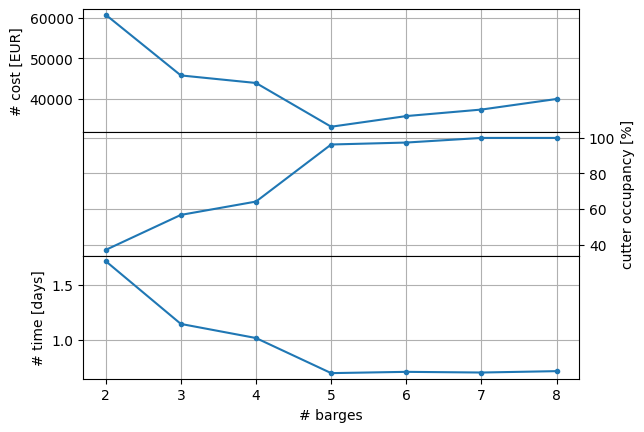

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)


axs[0].plot(n_barges,cost,'.-'), axs[0].set_ylabel('# cost [EUR]'),axs[0].grid();
# axs[0].set_xlabel('# barges');

axs[1].plot(n_barges,occupancy,'.-'), axs[1].set_ylabel('cutter occupancy [%]'),axs[1].grid();
# axs[1].set_xlabel('# barges');
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].plot(n_barges,duration,'.-'), axs[2].set_ylabel('# time [days]'),axs[2].grid();

axs[-1].set_xlabel('# barges');

## Visualize critical path of best scneario

For explanation of Critical Path see notebook 30

In [13]:
from openclsim.plot.critical_path import CpLog

In [28]:
i = 5 # many barges: 100% cutter config
vessels = results[i]['vessels']
activities = results[i]['activities']
cutter = vessels[cutter_name]
to_site = results[i][to_site_name]
from_site = results[i][from_site_name]
  
my_objects = list(vessels.values()) + [from_site, to_site]
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
t = f'{cutter_name} occupancy: ' + str(df.loc[cutter_name]['occupancy [%]'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t)

Occupancy "Cutter T": 100.0 % Total cost 37380.0
